### Imports

In [1]:
import itertools
import pandas as pd
import re
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

from bs4 import BeautifulSoup
from collections import Counter
from itertools import chain
from pandas.io.json import json_normalize
from pprint import pprint
from recipe_scrapers import scrape_me
from pymongo import MongoClient
from selenium import webdriver
from selenium.common.exceptions import TimeoutException, ElementNotInteractableException
from selenium.common.exceptions import ElementNotVisibleException, StaleElementReferenceException
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait as wait
from selenium.webdriver.support import expected_conditions as EC
from tqdm import tqdm_notebook as tqdm

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

### Create Parser for Cleaning Ingredients

In [31]:
# regex for separating ingredients list
SEPARATOR_RE = re.compile(r'^([\d\s*[\d\.,/]*)\s*(.+)')

# create a normalized string for ingredients
def normalize(st):
    """

    :param st:
    :return:
    """
    return re.sub(r'\s+', ' ', SEPARATOR_RE.sub('\g<1> \g<2>', st)).strip()


def escape_re_string(text):
    """

    :param text:
    :return:
    """
    text = text.replace('.', '\.')
    return re.sub(r'\s+', ' ', text)

# list of common units of measurements for ingredients
UNITS = {"cup": ["cups", "cup", "c.", "c"], "fluid_ounce": ["fl. oz.", "fl oz", "fluid ounce", "fluid ounces"],
         "gallon": ["gal", "gal.", "gallon", "gallons"], "ounce": ["oz", "oz.", "ounce", "ounces"],
         "pint": ["pt", "pt.", "pint", "pints"], "pound": ["lb", "lb.", "pound", "pounds"],
         "quart": ["qt", "qt.", "qts", "qts.", "quart", "quarts"],
         "tablespoon": ["tbsp.", "tbsp", "T", "T.", "tablespoon", "tablespoons", "tbs.", "tbs"],
         "teaspoon": ["tsp.", "tsp", "t", "t.", "teaspoon", "teaspoons"],
         "gram": ["g", "g.", "gr", "gr.", "gram", "grams"], "kilogram": ["kg", "kg.", "kilogram", "kilograms"],
         "liter": ["l", "l.", "liter", "liters"], "milligram": ["mg", "mg.", "milligram", "milligrams"],
         "milliliter": ["ml", "ml.", "milliliter", "milliliters"], "pinch": ["pinch", "pinches"],
         "dash": ["dash", "dashes"], "touch": ["touch", "touches"], "handful": ["handful", "handfuls"],
         "stick": ["stick", "sticks"], "clove": ["cloves", "clove"], "can": ["cans", "can"], "large": ["large"],
         "small": ["small"], "scoop": ["scoop", "scoops"], "filets": ["filet", "filets"], 
         "fillets": ["fillet", "fillets"], "sprig": ["sprigs", "sprig"],"jar":["jar","jars"], 
         "packet": ["packet","packets"], "package": ["package","packages"], "bottle":["bottle","bottles"],
         "slice":["slice","slices"], "cube":["cube","cubes"], "container":["container","containers"],
         "envelope":["envelope","envelopes"], "ground":["ground"], "quick":["quick"], "bunch":["bunch"]}

# numbers to separate quantities from ingredients
NUMBERS = ['seventeen', 'eighteen', 'thirteen', 'nineteen', 'fourteen', 'sixteen', 'fifteen', 'seventy', 'twelve',
           'eleven', 'eighty', 'thirty', 'ninety', 'twenty', 'seven', 'fifty', 'sixty', 'forty', 'three', 'eight',
           'four', 'zero', 'five', 'nine', 'ten', 'one', 'six', 'two', 'an', '½', '⅓','⅔','¼','¾','⅕','⅛','half',
          'halves','pieces','cubes','chunks','whole','cube', 'extra', 'pieces','piece','cube', 'long', 'jumbo', 'small',
          'medium', 'large', ]

prepositions = ["of"]

a = list(itertools.chain.from_iterable(UNITS.values()))
a.sort(key=lambda x: len(x), reverse=True)
a = map(escape_re_string, a)

PARSER_RE = re.compile(
    r'(?P<quantity>(?:[\d\.,][\d\.,\s/]*)?\s*(?:(?:%s)\s*)*)?(\s*(?P<unit>%s)\s+)?(\s*(?:%s)\s+)?(\s*(?P<name>.+))?' % (
        '|'.join(NUMBERS), '|'.join(a), '|'.join(prepositions)))


def parse(st):
    """

    :param st:
    :return:
    """
    st = normalize(st)
    res = PARSER_RE.match(st)
    
    return ((res.group('name') or '').strip())

### Load DataFrame of Recipes

In [2]:
df = pd.read_csv(r'/Users/stephaniekendall/Desktop/Errthang/Flatiron/projects/FP_Practice/6k_clean.csv',index_col=0)

In [3]:
# preview head
df.head()

,name,ingredients,clean
0,World's Best Lasagna,"['1 pound sweet Italian sausage', '3/4 pound lean ground beef', '1/2 cup minced onion', '2 cloves garlic, crushed', '1 (28 ounce) can crushed tomatoes', '2 (6 ounce) cans tomato paste', '2 (6.5 ounce) cans canned tomato sauce', '1/2 cup water', '2 tablespoons white sugar', '1 1/2 teaspoons dried basil leaves', '1/2 teaspoon fennel seeds', '1 teaspoon Italian seasoning', '1 1/2 teaspoons salt, divided, or to taste', '1/4 teaspoon ground black pepper', '4 tablespoons chopped fresh parsley', '12 lasagna noodles', '16 ounces ricotta cheese', '1 egg', '3/4 pound mozzarella cheese, sliced', '3/4 cup grated Parmesan cheese']","['sweet Italian sausage', 'lean ground beef', ' onion', 'garlic', ' tomatoes', 'tomato paste', ' tomato sauce', 'water', 'white sugar', ' basil leaves', 'fennel seeds', 'Italian seasoning', 'salt', 'ground black pepper', ' fresh parsley', 'lasagna noodles', 'ricotta cheese', 'egg', 'mozzarella cheese', ' Parmesan cheese']"
1,Pork Chops in Garlic Mushroom Sauce,"['2 pounds boneless pork chops', '1/2 teaspoon paprika', '1 pinch kosher salt and ground black pepper to taste', '1/4 cup butter, divided', '1 (8 ounce) package sliced fresh mushrooms', '4 cloves garlic, minced', '1 teaspoon Dijon mustard', '2 tablespoons all-purpose flour', '2 cups beef broth']","['pork chops', 'paprika', 'kosher salt and ground black pepper to taste', 'butter', 'package fresh mushrooms', 'garlic', 'Dijon mustard', 'all-purpose flour', 'beef broth']"
2,Super Duper Slow Cooker Beef Stroganoff,"['1 1/2 pounds cubed beef stew meat', 'salt and ground black pepper to taste', '1 onion, chopped', '1 (10.75 ounce) can condensed cream of mushroom soup', '1/4 cup water', '1 tablespoon dried chives', '2 cloves garlic, minced', '1 tablespoon Worcestershire sauce', '1 cube beef bouillon', '1/2 cup red wine', '1 tablespoon cornstarch', '1 tablespoon all-purpose flour', '1 (8 ounce) container sour cream', '1 (8 ounce) package sliced fresh mushrooms', '4 ounces cream cheese', '1/2 cup chopped fresh parsley']","[' beef stew meat', 'salt and ground black pepper to taste', 'onion', ' cream of mushroom soup', 'water', ' chives', 'garlic', 'Worcestershire sauce', 'cube beef bouillon', ' wine', 'cornstarch', 'all-purpose flour', 'container sour cream', 'package fresh mushrooms', 'cream cheese', ' fresh parsley']"
3,Chef John's Perfect Prime Rib,"['4 pounds prime rib roast', '1/4 cup unsalted butter, softened', '1 tablespoon freshly ground black pepper', '1 teaspoon herbes de Provence', 'kosher salt']","['prime rib roast', ' butter', ' ground black pepper', 'herbes de Provence', 'kosher salt']"
4,Beef Stroganoff for Instant Pot®,"['2 tablespoons canola oil', '1/2 onion, diced', '2 teaspoons salt, divided', '2 pounds beef stew meat, cut into 1-inch cubes', '1 teaspoon freshly ground black pepper', '3 cloves garlic, minced', '1/2 teaspoon dried thyme', '2 tablespoons soy sauce', '3 cups chopped mushrooms', '2 tablespoons all-purpose flour', '3 cups chicken broth', '1 (16 ounce) package wide egg noodles', '3/4 cup sour cream, or to taste']","['canola oil', 'onion', 'salt', 'beef stew meat', ' ground black pepper', 'garlic', ' thyme', 'soy sauce', ' mushrooms', 'all-purpose flour', 'chicken broth', 'package wide egg noodles', 'sour cream']"


In [17]:
# change ingredients string to a list of strings, remove punctuations
def list_me(string): 
    li = list(string.replace("'","").replace("[","").replace("]","").split(","))
    return li

In [32]:
# iterate through DataFrame and create nested list of clean ingredients
clean_ings = []
for values in df.clean:
    helping = []
    for string in list_me(values):
        helping.append(parse(string))
    clean_ings.append(helping)

In [37]:
# add the nested list back to the DataFrame and drop the old clean column
df['cleaned_ings'] = clean_ings
df.drop(columns=['clean'],inplace=True)

In [57]:
# load in DataFrame with avg. rating and total time for recipe completion
df1 = pd.read_csv(r'/Users/stephaniekendall/Desktop/Errthang/Flatiron/projects/FP_Practice/CSV Files/7k_noreviews.csv',index_col=0)
df1.drop(columns=['ingredients'],inplace=True)

In [59]:
# merge the DataFrames by name of recipe
df = df.merge(df1,left_on="name", right_on="name")

In [61]:
# sort the DataFrame by the cooking time
df.sort_values(by=['total time (min)'])

,name,ingredients,cleaned_ings,total time (min),avg. rating
2967,Chinese Noodle Chicken,"['4 skinless, boneless chicken breasts', '1 tablespoon vegetable oil', '½ cup sliced onion', '2 cups broccoli florets', '2 carrots, julienned', '2 cups snow peas', '4 cups dry Chinese noodles', '¼ cup teriyaki sauce']","[chicken breasts, vegetable oil, onion, broccoli florets, carrots, snow peas, dry Chinese noodles, teriyaki sauce]",0.0,4.23
1606,Rolled Dumplings,"['2 cups all-purpose flour', '2 teaspoons baking powder', '1 teaspoon salt', '1/3 cup shortening', '1/2 cup milk', '2 (14.5 ounce) cans chicken broth']","[all-purpose flour, baking powder, salt, shortening, milk, chicken broth]",0.0,4.69
1610,Baked Asian-Style Honey Chicken,"['1 (3 pound) whole chicken, cut into pieces', '3 tablespoons chopped onion', '2 tablespoons soy sauce', '1 tablespoon minced fresh ginger root', '1 teaspoon minced garlic', '2 tablespoons honey', '¼ cup chopped green onions']","[chicken, onion, soy sauce, fresh ginger root, garlic, honey, green onions]",0.0,4.28
1620,Tomato and Garlic Pasta,"['1 (8 ounce) package angel hair pasta', '2 pounds tomatoes', '4 cloves crushed garlic', '1 tablespoon olive oil', '1 tablespoon chopped fresh basil', '1 tablespoon tomato paste', 'salt to taste', 'ground black pepper to taste', '1/4 cup grated Parmesan cheese']","[angel hair pasta, tomatoes, garlic, olive oil, fresh basil, tomato paste, salt to taste, black pepper to taste, Parmesan cheese]",0.0,4.44
4076,Penne with Red Pepper Sauce and Broccoli,"['4 tablespoons olive oil', '1 ½ cups chopped onion', '2 cloves garlic, minced', '2 red bell peppers, chopped', '¼ cup almonds', '2 teaspoons balsamic vinegar', '½ teaspoon salt', 'freshly ground black pepper', '⅛ teaspoon cayenne pepper', '4 cups broccoli florets', '1 pound penne pasta', '⅓ cup grated Parmesan cheese', '½ cup fresh basil leaves, cut into thin strips']","[olive oil, onion, garlic, bell peppers, almonds, balsamic vinegar, salt, black pepper, cayenne pepper, broccoli florets, penne pasta, Parmesan cheese, fresh basil leaves]",0.0,4.13
1625,Turkey Pot Pie II,"['1 recipe pastry for a 9 inch double crust pie', '2 cups cubed cooked turkey', '2 cups frozen mixed vegetables, thawed', '2 tablespoons chopped onion', '1 (10.75 ounce) can condensed cream of chicken soup', '1/2 cup milk']","[recipe pastry for a 9 inch double crust pie, turkey, frozen vegetables, onion, cream of chicken soup, milk]",0.0,4.64
5146,Portuguese Cod Fish Casserole,"['2 pounds salted cod fish', '5 large potatoes, peeled and sliced', '3 large onions, sliced', '3/4 cup olive oil', '2 cloves garlic, minced', '1 tablespoon chopped fresh parsley', '1 1/2 teaspoons crushed red pepper flakes', '1 teaspoon paprika', '3 tablespoons tomato sauce']","[cod fish, potatoes, onions, olive oil, garlic, fresh parsley, pepper flakes, paprika, tomato sauce]",0.0,4.35
1626,"Pasta, Broccoli and Chicken","['12 ounces rigatoni pasta', '½ pound fresh broccoli florets', '¼ cup olive oil', '1 tablespoon minced garlic', '2 tablespoons pesto', '1 cup chopped tomatoes', '¾ cup grated Parmesan cheese', '1 pound boneless chicken breast halves, cooked and chopped', 'salt to taste', 'ground black pepper to taste']","[rigatoni pasta, fresh broccoli florets, olive oil, garlic, pesto, tomatoes, Parmesan cheese, chicken breast halves, salt to taste, black pepper to taste]",0.0,4.47
4075,Ricotta Stuffed Squash,"['8 yellow squash', '2 tablespoons butter', '1 onion, chopped', '1 clove garlic, minced', '1 (10 ounce) package frozen chopped spinach, thawed', '2 eggs', '2 cups ricotta cheese', '1/4 cup grated Parmesan cheese', '1 tablespoon chopped fresh parsley', '1/2 teaspoon salt', '1 teaspoon Italian seasoning', '1 pinch ground black pepper', '1 (26 ounce) jar spaghetti sauce']","[yellow squash, butter, onion, garlic, frozen spinach, eggs, ricotta cheese, Parmesan cheese, fresh parsley, salt, Italian seasoning, black pepper, spaghetti sauce]",0.0,4.11
4074,Spinach Garlic Pasta,"['1 (16

In [64]:
# find the number of recipes with no/0 cooking time
len(df.loc[df['total time (min)'] == 0])

454

In [65]:
# sort by rating, see unrated items
df.sort_values(by=['avg. rating'])

,name,ingredients,cleaned_ings,total time (min),avg. rating
13,Al's Burmese Chicken Curry,"['1 teaspoon butter, or as needed', '8 shallots, thinly sliced', '3 tablespoons red curry paste, or more to taste', '2 tablespoons hot curry powder', '1 tablespoon ground red chile pepper', '2 1/2 pounds chicken thighs', '1 lemongrass, smashed and cut into 1-inch pieces', ""10 bird's eye chile peppers, chopped, or to taste"", '1 tablespoon ground coriander', '2 kaffir lime leaves, or to taste', '3 tablespoons fish sauce', 'water to cover', '1 (14 ounce) can coconut milk', '4 tomatoes, quartered', '1/2 small bunch fresh cilantro, chopped, or to taste']","[butter, shallots, curry paste, hot curry powder, chile pepper, chicken thighs, lemongrass, ""birds eye chile peppers"", coriander, kaffir lime leaves, fish sauce, water to cover, coconut milk, tomatoes, fresh cilantro]",180.0,0.00
14,Gemelli Pasta with Roasted Pumpkin and Pancetta,"['2 cups peeled, cubed pumpkin', '2 tablespoons extra-virgin olive oil, divided', '1 teaspoon fresh thyme', '1/4 teaspoon salt', '1/8 teaspoon ground black pepper', '1/2 (16 ounce) package gemelli pasta', '1 (4 ounce) package diced pancetta', '1 cup chicken broth', '1/4 cup grated Parmigiano-Reggiano cheese']","[, -virgin olive oil, fresh thyme, salt, black pepper, gemelli pasta, pancetta, chicken broth, Parmigiano-Reggiano cheese]",55.0,0.00
5396,Quick Polynesian Chicken,"['6 chicken thighs', '1 (15.25 ounce) can fruit cocktail']","[chicken thighs, fruit cocktail]",0.0,2.92
5217,Spinach Mushroom and Ricotta Fettuccine,"['1 (16 ounce) package spinach fettuccine pasta', '1 teaspoon butter', '3 cups mushrooms', '1 (10 ounce) package frozen chopped spinach', '1 (15 ounce) container ricotta cheese', '1 lemon, juiced']","[spinach fettuccine pasta, butter, mushrooms, frozen spinach, ricotta cheese, lemon]",30.0,2.93
3962,Old-Fashioned Chicken and Dumplings,"['1 (3 pound) whole chicken', '4 cubes chicken bouillon', '2 cups all-purpose flour', '4 eggs', '1 teaspoon salt']","[chicken, chicken bouillon, all-purpose flour, eggs, salt]",200.0,3.07
4755,Dee's Special Chicken,"['4 skinless, boneless chicken breast halves', 'salt and pepper to taste', '1 teaspoon dried rosemary', '1 teaspoon dried sage', '1 teaspoon dried thyme', '6 cloves garlic', '1 (12 fluid ounce) can or bottle beer', '2 sprigs fresh parsley, for garnish']","[chicken breast halves, salt and pepper to taste, rosemary, sage, thyme, garlic, or bottle beer, fresh parsley]",0.0,3.08
5294,Slow Cooker Chicken Curry with Quinoa,"['1 ½ pounds diced chicken breast meat', '¾ cup chopped onion', '1 ¼ cups chopped celery', '1 ¾ cups chopped Granny Smith apples', '1 cup chicken broth', '¼ cup nonfat milk', '1 tablespoon curry powder', '¼ teaspoon paprika', '⅓ cup quinoa']","[chicken breast meat, onion, celery, Granny Smith apples, chicken broth, nonfat milk, curry powder, paprika, quinoa]",270.0,3.15
5068,Chicken A La Orange,"['4 skinless, boneless chicken breasts', '1 tablespoon vegetable oil', '2 ½ cups orange juice', '3 tablespoons cornstarch', '½ cup hot water', '3 tablespoons honey', '¼ teaspoon ground ginger']","[chicken breasts, vegetable oil, orange juice, cornstarch, hot water, honey, ginger]",40.0,3.15
4130,Baked Zucchini Cakes,"['2 cups shredded zucchini', '1 cup Italian seasoned bread crumbs', '1 egg', '1 tablespoon mayonnaise', '1 teaspoon prepared mustard', '1 tablespoon Old Bay Seasoning TM']","[zucchini, Italian bread crumbs, egg, mayonnaise, mustard, Old Bay Seasoning TM]",55.0,3.19
5362,Chicken and Sweet Potato Bake,"['1 large McIntosh apple - peeled, cored, and diced', '2 sweet potatoes, peeled and cubed', '1 small onion, sliced', '1 teaspoon ground nutmeg', '1 teaspoon ground cinnamon', '1 teaspoon ground ginger', 'salt and pepper to taste', '2 bone-in chicken breast halves']","[McIntosh apple -, sweet potatoes, onion, nutmeg, cinnamon, ginger, salt and pepper to taste, bone-in chicken breast halves]",60.0,3.22


In [83]:
# find all the variations of chicken breast 
subs = 'chicken breast'

res = [i for sub_list in clean_ings for i in sub_list if subs in i]

print(str(res))

['chicken breast halves', 'chicken breast halves', 'chicken breast halves -', 'chicken breast halves', 'chicken breast halves', 'frozen chicken breast halves', 'chicken breast halves', 'chicken breast halves - 1/4 inch thick', 'chicken breast halves', 'chicken breast halves', 'chicken breast meat', 'chicken breast halves - cut into 1 inch cubes', 'chicken breast halves - cut into 1/2 inch strips', 'chicken breast halves -', 'chicken breast halves', 'chicken breasts', 'chicken breast halves', 'chicken breast halves', 'chicken breast halves', 'chicken breast halves', 'chicken breast halves - thin', 'chicken breasts', 'chicken breast halves', 'chicken breast halves', 'chicken breast meat - cut into chunks', 'chicken breast halves', 'chicken breast halves - cut into 1 inch cubes', 'chicken breast halves - to 1/2 inch thickness', 'chicken breasts', 'chicken breast halves', 'chicken breast halves', 'chicken breast halves', 'chicken breast meat -', 'chicken breast halves', 'chicken breast hal

In [97]:
# replace all instances of chicken breast to simply chicken breast
sorted_ings = []
for values in df.cleaned_ings:
    helping = []
    for string in values:
        if 'chicken breast' in string:
            helping.append(string.replace(string,'chicken breast'))
        else:
            helping.append(string)
    sorted_ings.append(helping)

In [99]:
# add replaced list to DataFrame
df['ings_cleaned'] = sorted_ings

In [119]:
# find any duplicates
df['name'].value_counts()

All-Star Veggie Burger                               1
Spicy Unstuffed Cabbage                              1
Salmon Fillets with Creamy Dill                      1
Thai Red Chicken Curry                               1
Herbed Chicken Pasta                                 1
Chef John's Crab-Stuffed Sole                        1
Easy French Toast Casserole                          1
Hamburger Muffins                                    1
Spicy Shrimp and Grits                               1
Fettucine Carbonara                                  1
Dumpling Soup                                        1
Pasta Pascal                                         1
Tahini Chicken                                       1
BBQ Chuck Roast                                      1
Chicken Something                                    1
Tofu Parmigiana                                      1
Tofu Keema                                           1
The Real Reuben                                      1
Roast with

In [117]:
# remove duplicates of 'Mexican Casserole'
# index not reset
df.drop([325, 327], inplace = True)

# append II to the 2nd Mexican Casserole recipe
df.at[326,'name'] = 'Mexican Casserole II'

### EDA

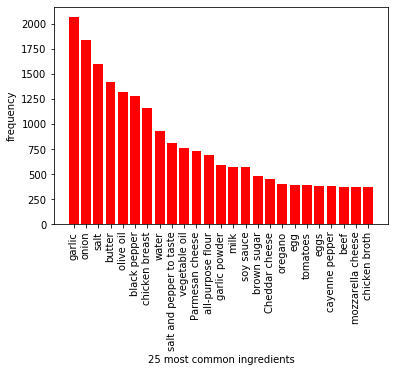

<Figure size 720x1080 with 0 Axes>

In [109]:
# flatten list for count of values
flat_list = [item for sublist in sorted_ings for item in sublist]

# create bar chart for most common words
w = Counter(flat_list)
most_occur = w.most_common(25)

word, frequency = zip(*most_occur)
indices = np.arange(len(word))
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.xlabel('25 most common ingredients')
plt.ylabel('frequency')
# plt.tight_layout()

plt.figure(figsize=(10,15))
plt.show()